In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

In [2]:
from skimage.measure import find_contours
from scipy.ndimage.morphology import distance_transform_edt

In [3]:
xy_pixel_distance_lossless = 0.46

distance_accepted_um = 50.
distance_accepted_lossless = distance_accepted_um / xy_pixel_distance_lossless
distance_accepted_tb = distance_accepted_lossless / 32.

In [4]:
from skimage.util import pad

In [5]:
# for stack in ['MD594', 'MD585', 'MD593', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
for stack in ['MD603']:

    print stack

    first_bs_sec, last_bs_sec = section_range_lookup[stack]
    
    dm = DataManager(stack=stack)

    for sec in range(first_bs_sec, last_bs_sec+1):

        dm.set_slice(sec)
        m = dm.load_thumbnail_mask()
        
        mp = pad(m, ((5,5), (5,5)), mode='constant')
        
        cnts = find_contours(mp, .5) # y, x
        lengths = map(len, cnts)
        cnt = cnts[np.argmax(lengths)].astype(np.int) - (5,5)
        ys = cnt[:,0]
        xs = cnt[:,1]
        cnt2 = cnt[(ys > 5) & (xs > 5) & (m.shape[1]-1-xs > 5) & (m.shape[0]-1-ys > 5)].astype(np.int)

        m2 = np.zeros_like(m)
        m2[cnt2[:,0], cnt2[:,1]] = 1

        distance_to_contour = distance_transform_edt(~m2)

        contour_prob_map = np.exp(-distance_to_contour**2/(2*distance_accepted_tb)**2)
        contour_prob_map[contour_prob_map < 1e-2] = 0

        contourMap_rootdir = create_if_not_exists('/oasis/projects/nsf/csd395/yuncong/CSHL_outerContourMap')
        contourMap_dir = create_if_not_exists(contourMap_rootdir + '/%(stack)s/%(sec)04d/' % {'stack': stack, 'sec': sec})

        img_fn = contourMap_dir + '/%(stack)s_%(sec)04d_denseScoremapThumbnail_outerContour.hdf' % {'stack': stack, 'sec': sec}

        save_hdf(contour_prob_map, img_fn)

MD603


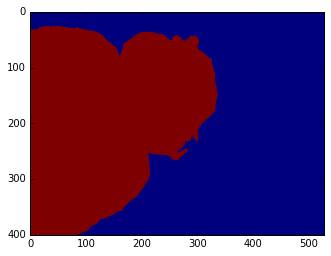

In [6]:
plt.imshow(m);

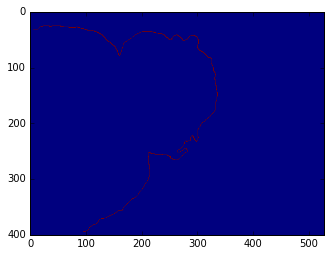

In [7]:
plt.imshow(m2);

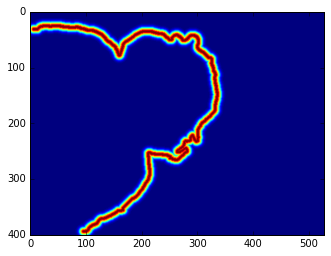

In [8]:
plt.imshow(contour_prob_map)